In [111]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib qt
import pandas
import pathlib
import re
import numpy as np
# import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation
import json
from typing import Tuple

cwd = pathlib.Path.cwd()

G = 6.67408e-11
YEARS = 1
SCALE = 1000
SECONDS = 60*60*24/SCALE  # number of seconds in a day
tseconds = 365*SECONDS  # number of seconds in a year
X = RN = 0  # I prefer doing this rather then using the numerical index
Y = VN = 1  # now I can plug these in and remind myself what this physically represents rather then remember which index I'm calling
dt = SECONDS
print(SECONDS)
print(tseconds)

86.4
31536.000000000004


In [112]:
def import_bodies() -> tuple:
    '''
    Reads the AstronomicalObjects.json and puts it in a vector.
    '''
    with open(cwd / "AstronomicalObjects.json", 'r') as json_file:
        json_data = json.load(json_file)
        system_data = json_data["System"]

        body_names = []
        mass = np.zeros((len(system_data), 1))
        rn = np.zeros((len(system_data), 1, 2))
        vn = np.zeros((len(system_data), 1, 2))

        for i, obj in enumerate(system_data.values()):
            body_names.append(obj["name"])
            mass[i] = obj["m"]
            
            rn[i][0][X] = obj["x0"]
            rn[i][0][Y] = obj["y0"]

            vn[i][0][X] = obj["vx0"]
            vn[i][0][Y] = obj["vy0"]

        return tuple(body_names), mass, rn, vn

        #     system.append(body)

        # return tuple(system)

In [113]:
def acc(rn: np.array, gm: np.array) -> np.array:
    '''
    rn is a Nx2 vector, and gm is a Nx1 vector. Note: gm should be mass * G * (-1)
    Yields the dv/dt = k value

    dv/dt = -G Sum[ Mj * (ri + (dri*h) - rj)/(ri + (dri*h) - rj)**3]
    '''

    an = np.zeros(shape = (rn.shape[0], 2))

    for i, ri in enumerate(rn):
        xi, yi = ri

        for j, rj in enumerate(rn):
            if j != i:
                xj, yj = rj

                r = np.sqrt((xi - xj)**2 + (yi - yj)**2)

                a = gm[j] / r**3

                an[i][X] += a * (xi - xj)
                an[i][Y] += a * (yi - yj)

    return an


def RK4(mass: np.array, rn: np.array, vn: np.array, h: float):
    '''
    Takes an Nx2 matrix for position & velocity, and Nx1 matrix for mass
    '''
    dr1 = h*vn
    dv1 = h*acc(rn, mass)

    dr2 = h*(vn + dv1/2)
    dv2 = h*acc(rn + (dr1/2), mass)
    
    dr3 = h*(vn + dv2/2)
    dv3 = h*acc(rn + (dr2/2), mass)

    dr4 = h*(vn + dv3)
    dv4 = h*acc(rn + (dr3), mass)

    return (1/6)*(rn + (dr1 + 2*dr2 + 2*dr3 + dr4)), (1/6)*(vn + (dv1 + 2*dv2 + 2*dv3 + dv4))


def orbits(time_steps: int, body_names: tuple, mass: np.array, rn_data: np.array, vn_data: np.array, h: float):
    '''
    '''

    rn = rn_data[:, 0, :]
    vn = vn_data[:, 0, :]

    n_bodies = len(body_names)

    t = 0
    n = 0
    while t < time_steps:
        rn, vn = RK4(mass, rn, vn, h)

        rn_data = np.concatenate([rn_data, np.reshape(rn, (n_bodies, 1, 2))], axis = 1)
        vn_data = np.concatenate([vn_data, np.reshape(vn, (n_bodies, 1, 2))], axis = 1)

        t += h
        n += 1

    print(n)

    return rn_data


In [114]:
body_names, mass, rn, vn = import_bodies()

mass = (-1) * G * mass

rn = orbits(dt*5, body_names, mass, rn, vn, dt)
print(rn.shape)

print(rn[1])

# print(rn[1])
# print(rn[1, :, X])


5
(2, 6, 2)
[[ 1.52000000e+11  0.00000000e+00]
 [ 2.53333333e+10  2.53065600e+06]
 [ 4.22222140e+09  8.43551918e+05]
 [ 7.03674230e+08  2.10882114e+05]
 [ 1.16222285e+08  4.65459011e+04]
 [-2.48965946e+07 -8.14095383e+03]]


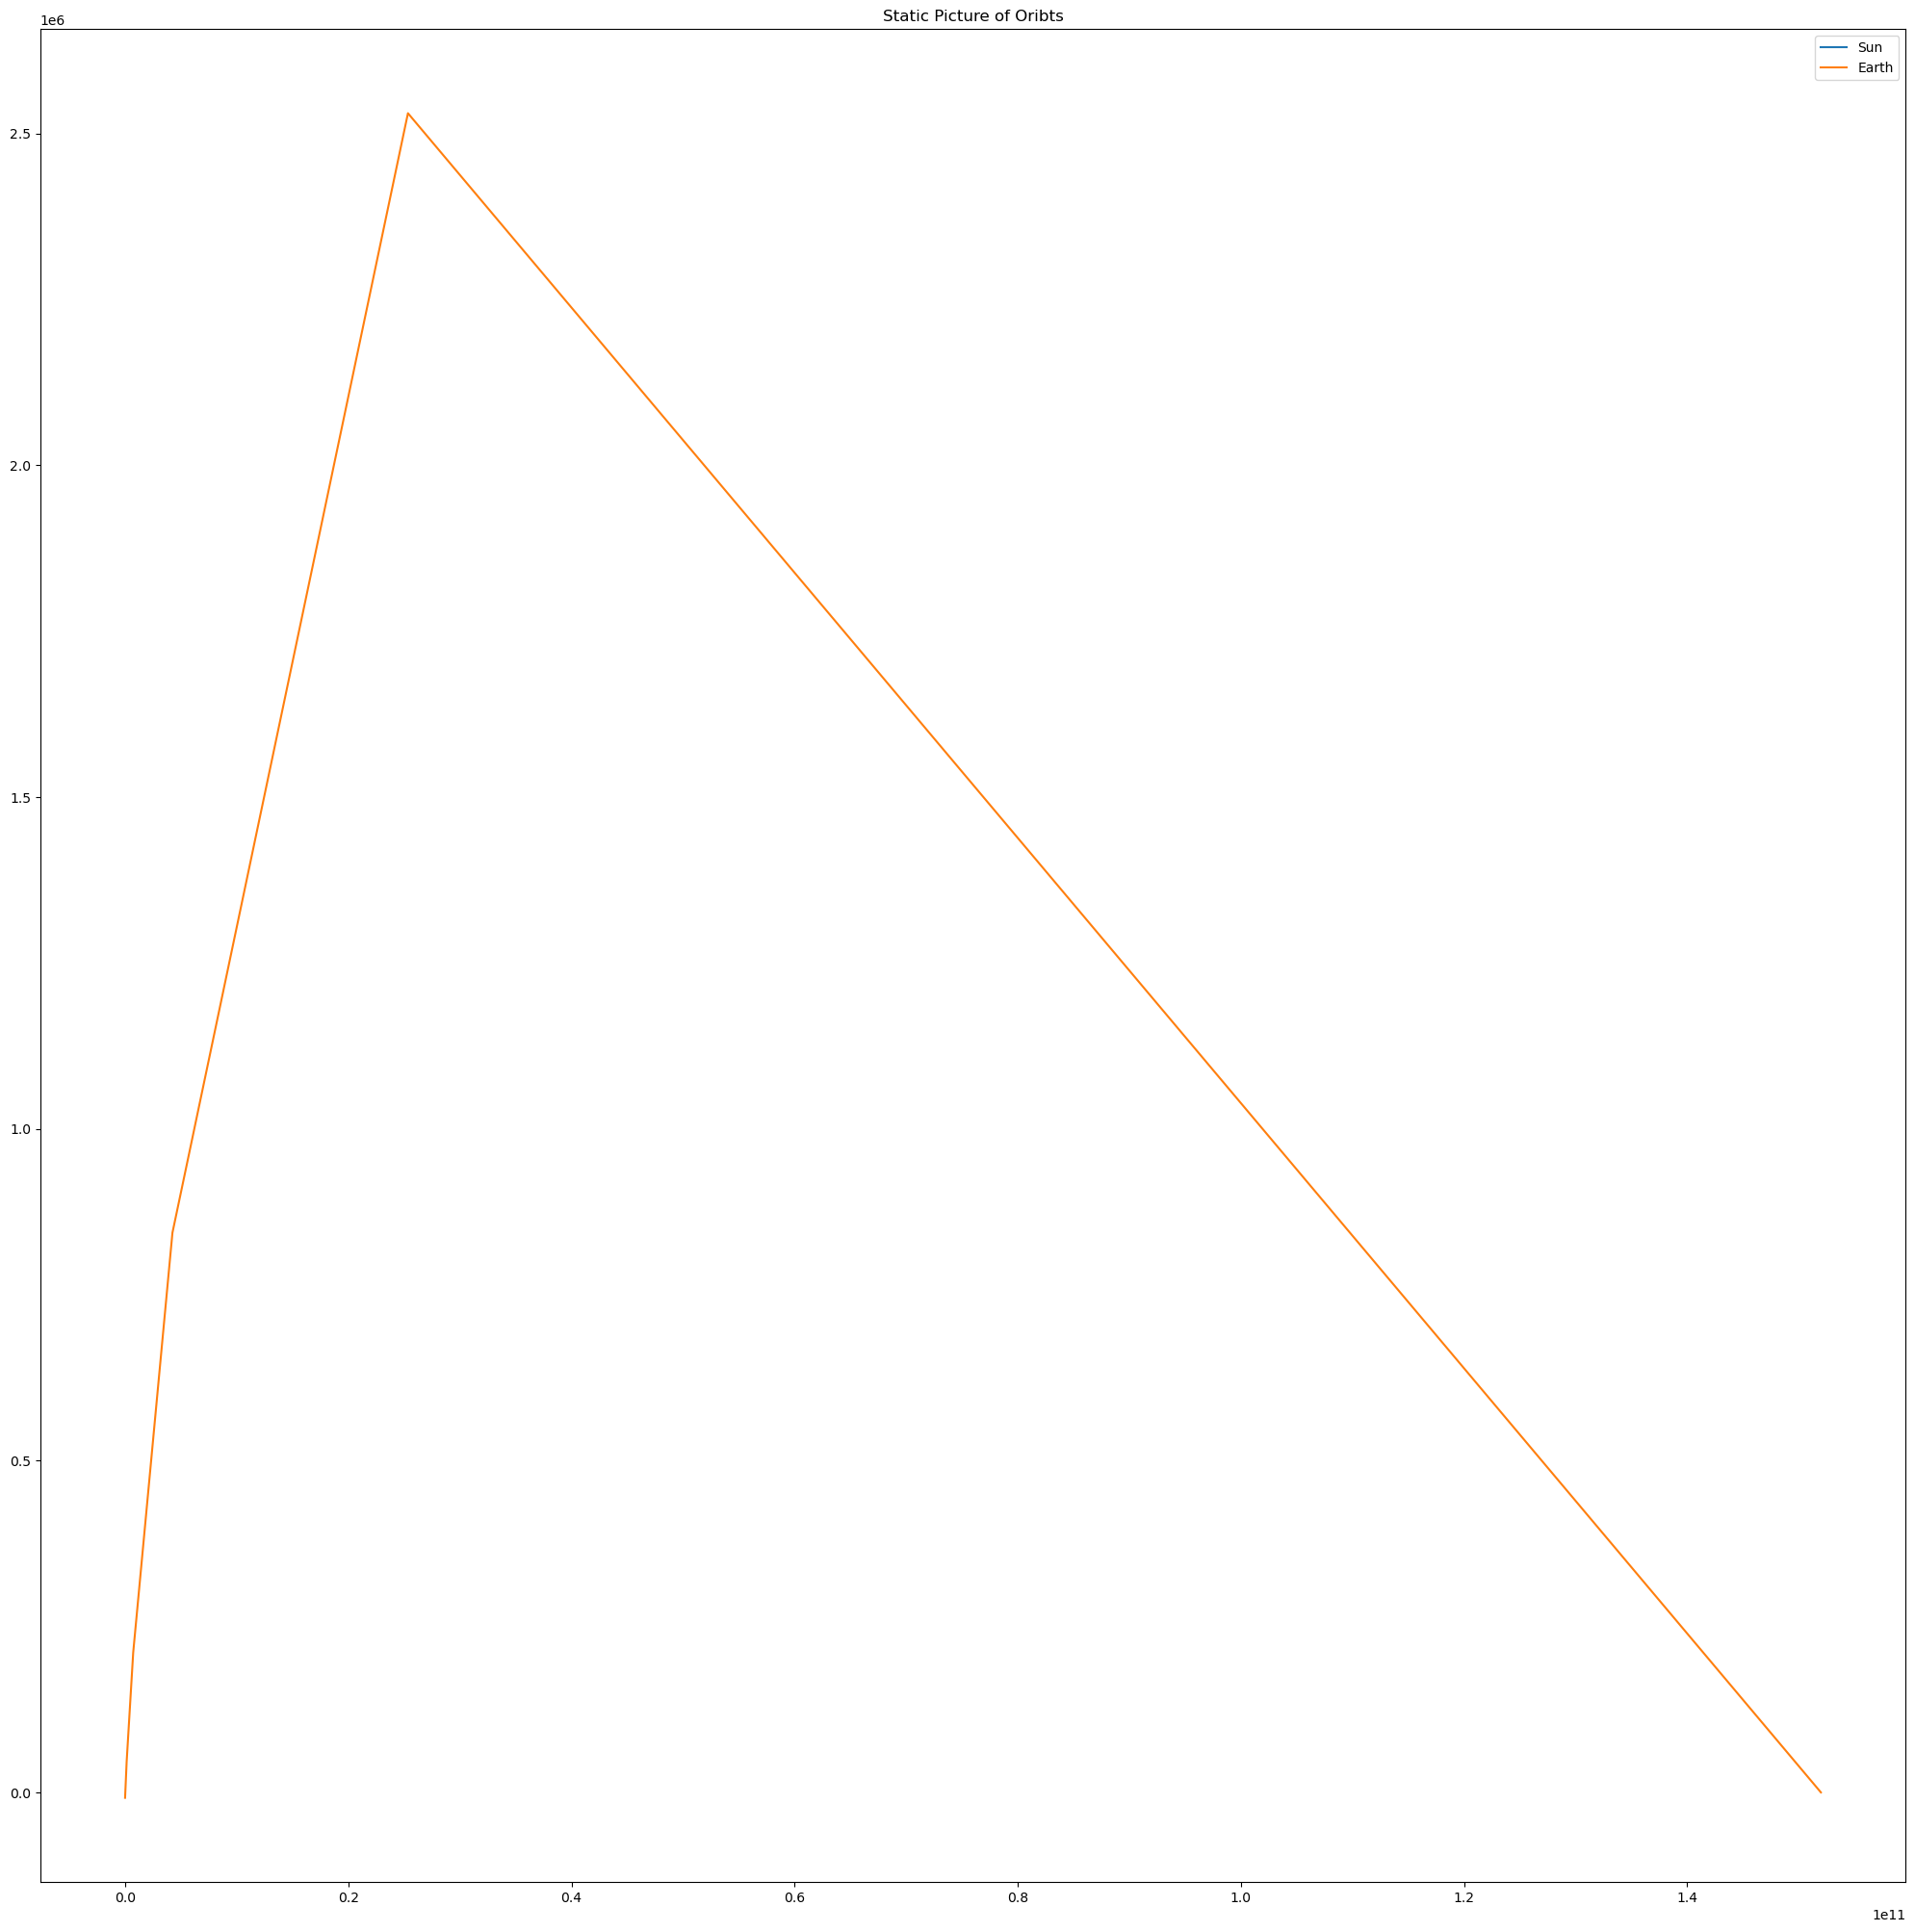

In [115]:
plt.figure(figsize = (25, 25))

n_bodies = len(mass)

for body in range(n_bodies):
    x_data = rn[body, :, X]
    y_data = rn[body, :, Y]
    plt.plot(x_data, y_data, label = body_names[body])

plt.legend()
plt.title("Static Picture of Oribts")
plt.savefig(str(cwd / f"Static_Orbits_for_{YEARS}_years.png"))
plt.show()